In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import math

### load data function

In [4]:


def load_data(root='data/CroppedYaleB', reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [6]:
#add salt and pepper noise function
def salt_pepper_noise(image, salt = True, pepper = False, noise_level=0.05):

    #set dimensions
    out_image = image.copy()
    orginal_dims = out_image.shape[0]

    #set percentage noise
    num_noise_pixels = int(orginal_dims*noise_level)

    if pepper:
        #add black points
        black_points = random.sample(range(orginal_dims), k=num_noise_pixels)

        #add black dots to image
        out_image[black_points] = 0

    if salt:
        #white points
        white_points = random.sample(range(orginal_dims), k=num_noise_pixels)

        #add white points to images
        out_image[white_points] = 255

    return out_image

## Euclidean multiplicative update alogrithm

In [7]:
"""
https://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf
V = WH

W = (n x r) matrix
H = (r x m) matrix

cost function SSE = sum(V-WH)**2

multiplicative update rules
 H = H*(W.T@V)/(W.T@W@H)
 W = W(V@H.T)/(W@H@HT)
 
 check error
 
 itterate

"""

def euclidean_multiplicative_update (V, r, iteration):
    
    loss = []
    W = np.random.rand(V.shape[0],r)*255
    H = np.random.rand(r,V.shape[1])*255
    
    for i in range(iteration):
        H = H*(W.T@V)/(W.T@W@H)
        W = W*(V@H.T)/(W@H@H.T)
        l = np.sum((V-W@H)**2)
        loss.append(l)
        
    return W, H, loss        


In [32]:
'''
https://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf
implimentation from page 3 formula 5
'''

def KL_divergence_update(V,r,iteration):

    loss = []
    W = np.random.rand(V.shape[0],r)*255
    H = np.random.rand(r,V.shape[1])*255
    
    for i in range(iteration):
        H = H * np.dot(W.T,V / np.dot(W,H)) / np.sum(W,0)[:,None]
        W = W * np.dot(V / np.dot(W,H),H.T) / np.sum(H,1)
        l=np.sum(V*np.log((V++1e-10)/(W@H))-V+(W@H))
        loss.append(l)
        
    return W, H, loss 
    

## Algorithm: NMF with L1 sparseness constraints

In [33]:
def hoyers_projection(x, L1_constraint):
    
    #determine parameters
    n = len(x)
    L1 = np.sum(x)
    L2 = np.sum(x**2) 
    e = np.ones(n)
    
    #zero coefficients
    zero_coeff = []
    
    s = x+(L1_constraint-L1)/(n) 
    
    s = s.flatten()

    n_iter = 0
    
    while True:
        
        #set zero coefficents in mid point to zero 
        #mid point
        m = np.ones(n)*L1_constraint/(n-len(zero_coeff))
        m[zero_coeff] = 0
        w = s-m
        w_T = w.T
        a = np.sum(w**2)
        b = (s@w_T)*2
        c = np.sum(s**2)-L2

        #solve quadratic
        alpha = (-b+math.sqrt(b**2-4*a*c))/(2*a)

        s = alpha*w + s
        
        if (s>=0).all():
            n_iter += 1
            break

        n_iter += 1
        
        negatives = np.where(s<=0)[0]
        
        negatives = [i for i in negatives if i not in zero_coeff]
        
        zero_coeff.extend(negatives)
        
        s[zero_coeff] = 0
        
        tempsum = sum(s)
        
        s = s + (L1_constraint-tempsum)/(n-len(zero_coeff))
        
        s[zero_coeff] = 0
        
        if n_iter == n:
            break
                
    return s, n_iter


In [42]:
def NMFS2(V,r,Hs,Ws,muH,muW, iterations):
    
    #Hs set sparesness of H between [0:1]
    #Ws set sparesness of W between [0:1]
    #r new dimension
    #muH step size for gradient descent
    #muW step size for gradient descent
    
    #shape of input matrix
    m = V.shape[0]
    n = V.shape[1]
    V=V
    
    #set error
    error = []

    #randomly intialise W & H
    W = np.random.rand(V.shape[0],r)*255
    H = np.random.rand(r,V.shape[1])*255
    
    #set intial error
    l = np.sum((V-W@H)**2)
    error.append(l)
       
    #If sparseness constraints on W apply, then project each column of W to be non-negative, have
    #unchanged L2 norm, but L1 norm set to achieve desired sparseness
    if Ws is not None:
        L1a = (math.sqrt(m)-(math.sqrt(m)-1)*Ws)
        for i in range(0,r):
            W[:,i] = hoyers_projection(W[:,i],L1a*np.linalg.norm(W[:,i]))[0]
    
     #If sparseness constraints on H apply, then project each row of H to be non-negative, have unit
     #L2 norm, and L1 norm set to achieve desired sparseness
    if Hs is not None:
        #normalise L2 to unit norm
        H = H / np.linalg.norm(H.T, axis=1)
        L1s = math.sqrt(n)-(math.sqrt(n)-1)*Hs 
        for i in range(0,r):
            H[i,:] = hoyers_projection(H[i,:],L1s*np.linalg.norm(H[i,:]))[0]
    
    for x in range(0,iterations):
    
        #Iterate

        #If sparseness constraints on W apply,
            #i. Set W := W−µW(WH−V)HT
            #ii. Project each column of W to be non-negative, have unchanged L2 norm, but L1
            #norm set to achieve desired sparseness
            #else take standard multiplicative step W := W⊗(VHT)/(WHHT)
        if Ws is not None:
            W = W-muW*((W@H-V)@H.T)
            for i in range(0,r):
                W[:,i] = hoyers_projection(W[:,i],L1a*np.linalg.norm(W[:,i]))[0]
        else:
             W = W*(V@H.T)/(W@H@H.T)

         #If sparseness constraints on H apply,
            #i. Set H := H−µHWT(WH−V)
            #ii. Project each row of H to be non-negative, have unit L2 norm, and L1 norm set to achieve desired sparseness
            #else take standard multiplicative step H := H⊗(WTV)/(WTWH)
        if Hs is not None:
            H = H-muH*(W.T@(W@H-V))
            for i in range(0,r):
                H[i,:] = hoyers_projection(H[i,:],L1s*np.linalg.norm(H[i,:]))[0]
        else:
            H = H*(W.T@V)/(W.T@W@H)

        l = np.sum((V-W@H)**2)
        error.append(l)

    

    return W,H, error
    

In [12]:
#set dims
orldims = (112,92)
yalebdims = (192,168)

In [5]:
# Load ORL dataset.
X, Y = load_data(root='data/ORL', reduce=1)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

ORL dataset: X.shape = (10304, 400), Y.shape = (400,)


## Analysis using euclidean updates

In [10]:
W, H, loss  = euclidean_multiplicative_update(X, 10, 300)

300


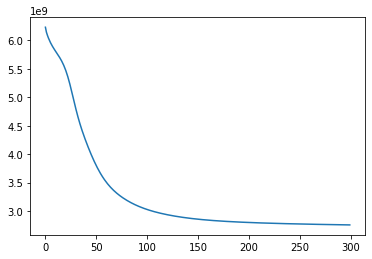

In [11]:
print(len(loss))
plt.plot(range(0,len(loss)),loss)

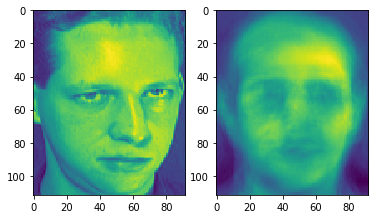

In [38]:
#view image then view recreation
recon = W@H
f, axarr = plt.subplots(1,2)
axarr[0].imshow(X[:,1].reshape(orldims))
axarr[1].imshow(recon[:,1].reshape(orldims))

## Analysis using KL divergence update

In [39]:
#run MNF using KL divergence 
W, H, loss  = KL_divergence_update(X, 10, 300)

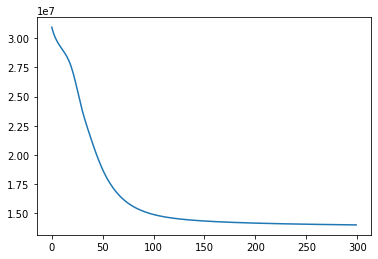

In [40]:
plt.plot(range(0,len(loss)),loss)

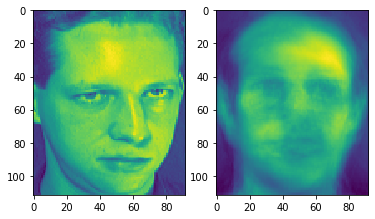

In [41]:
recon = W@H
f, axarr = plt.subplots(1,2)
axarr[0].imshow(X[:,1].reshape(orldims))
axarr[1].imshow(recon[:,1].reshape(orldims))

## Analysis using L1 sparseness

In [ ]:
Wnew,Hnew, error = NMFS2(X,50,None,0.6,0.002,0.002,50)
plt.plot(range(0,len(error)),error)